<a href="https://colab.research.google.com/github/EronDS/Neural-Networks/blob/main/CNNs/Images/Pulmonary_Infections_Identifier/Chest_ScanCLF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import keras 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.model_selection import train_test_split
from keras.models import Sequential , Model
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout, Activation, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import plot_model
from keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, CSVLogger
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import ResNet50, VGG16, VGG19, InceptionV3, InceptionResNetV2, ResNet101
import math 
import warnings 
warnings.filterwarnings('ignore')


###Importing and managing dataset

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Data/Covid/Chest_xray_Corona_Metadata.csv')
df

Unnamed: 0  ... Label_1_Virus_category
0              0  ...                    NaN
1              1  ...                    NaN
2              2  ...                    NaN
3              3  ...                    NaN
4              4  ...                    NaN
...          ...  ...                    ...
5905        5928  ...                  Virus
5906        5929  ...                  Virus
5907        5930  ...                  Virus
5908        5931  ...                  Virus
5909        5932  ...                  Virus

[5910 rows x 6 columns]

In [3]:
df['Dataset_type'].value_counts()

TRAIN    5286
TEST      624
Name: Dataset_type, dtype: int64

In [4]:
train_df = df[: 5286]
test_df = df[5286:]

In [5]:
train_folder = '/content/drive/MyDrive/Data/Covid/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
test_folder = '/content/drive/MyDrive/Data/Covid/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'


In [6]:
train_imgs = ['/content/drive/MyDrive/Data/Covid/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/{}'.format(i) for i in train_df.X_ray_image_name]
test_imgs = ['/content/drive/MyDrive/Data/Covid/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/{}'.format(i) for i in test_df.X_ray_image_name]

### **Example of Wild-Data present in Dataset** ####

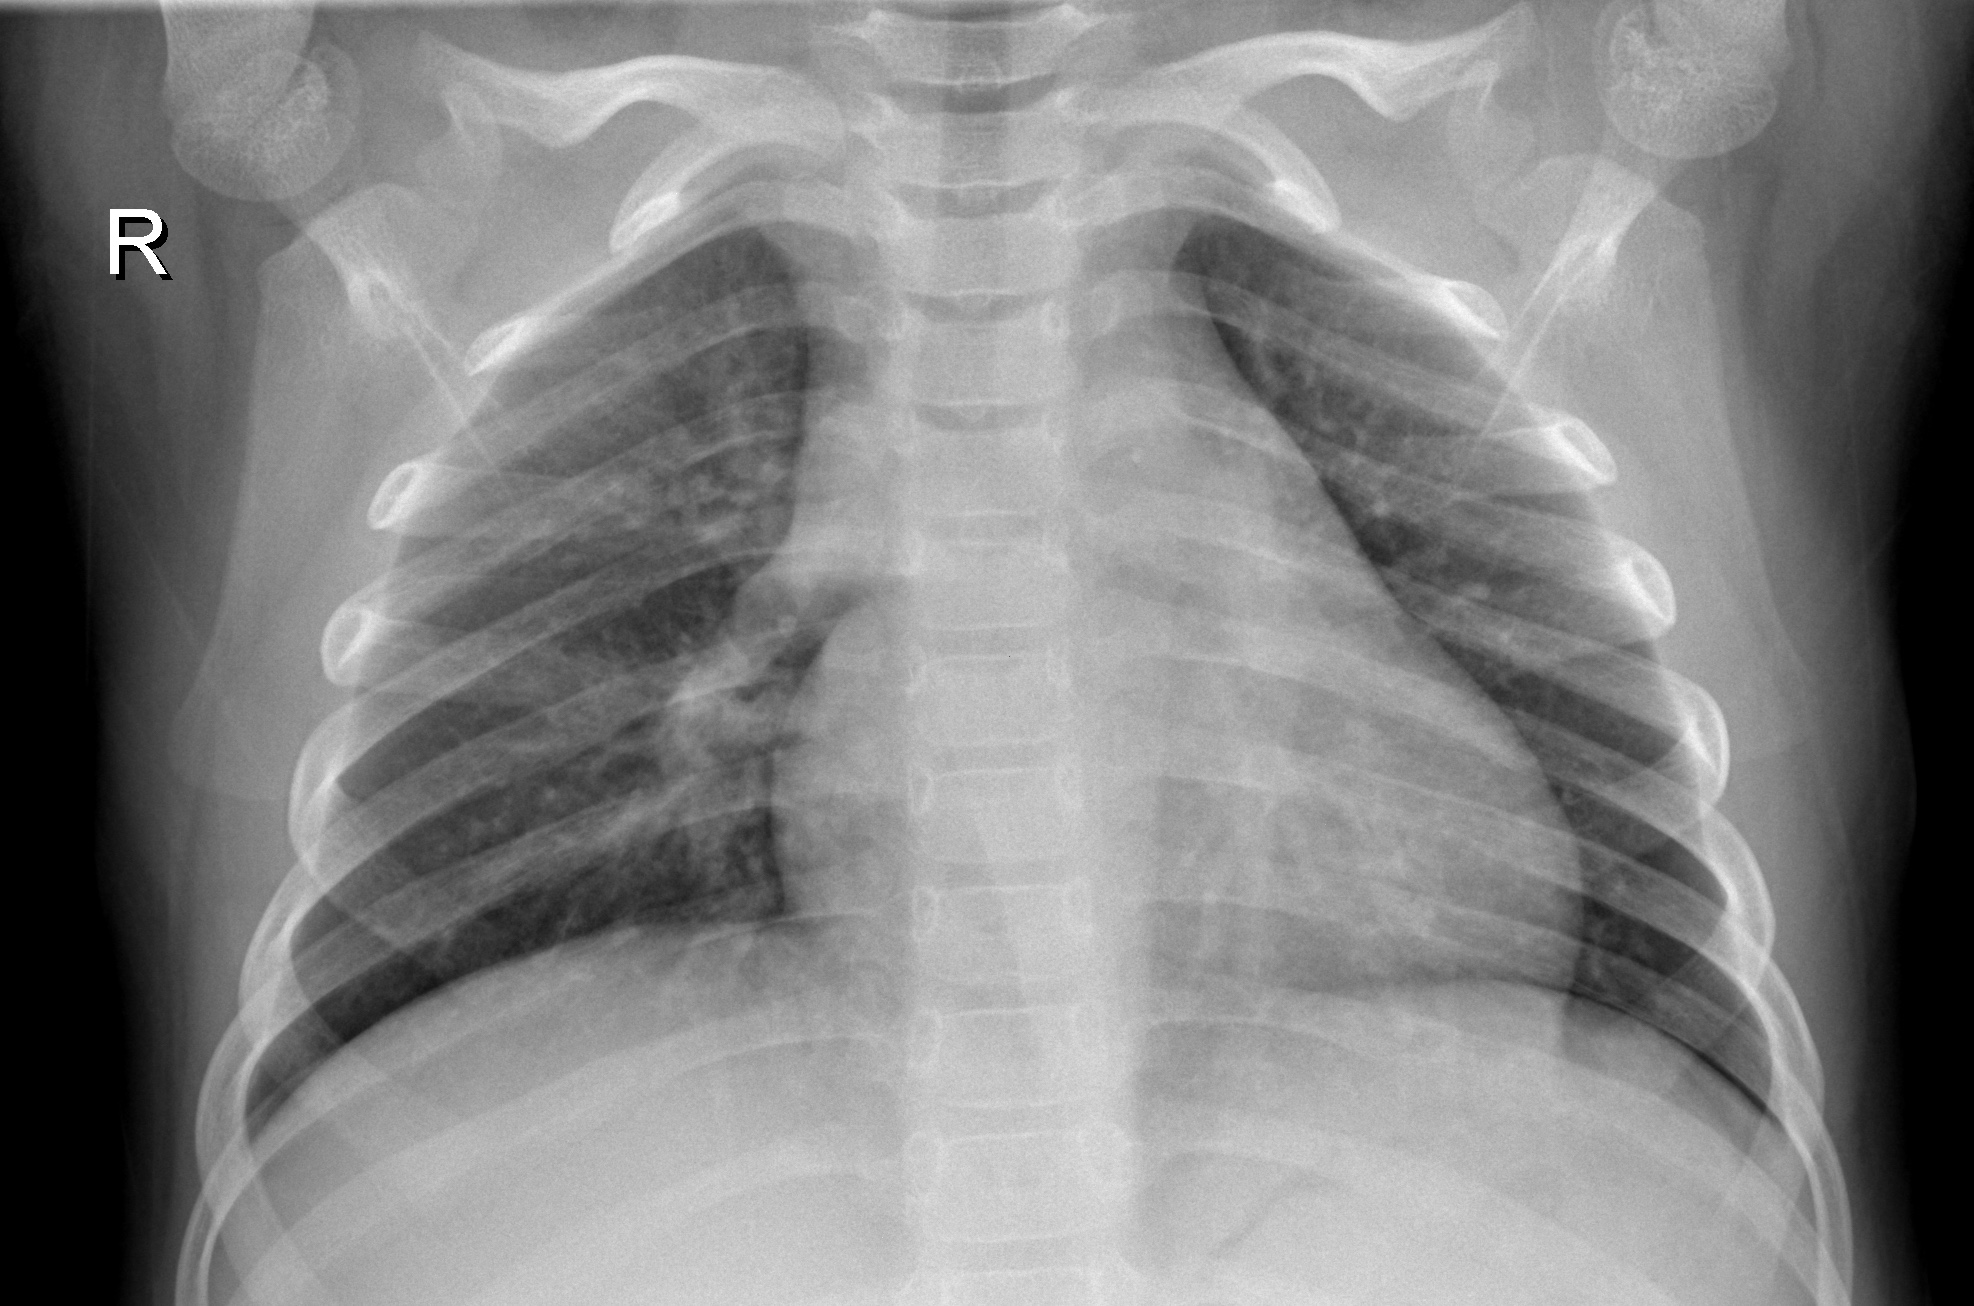

In [7]:
Image.open(train_imgs[1])

In [8]:

normal_idxs = [] 
pnemonia_idxs = []

idx = 0
for i in range(len(train_df.Label)):
  if train_df.Label[i] == 'Normal':
    normal_idxs.append(i)
  if train_df.Label[i] == 'Pnemonia':
    pnemonia_idxs.append(i)

### **Normal Chest X-Ray Examples** ###


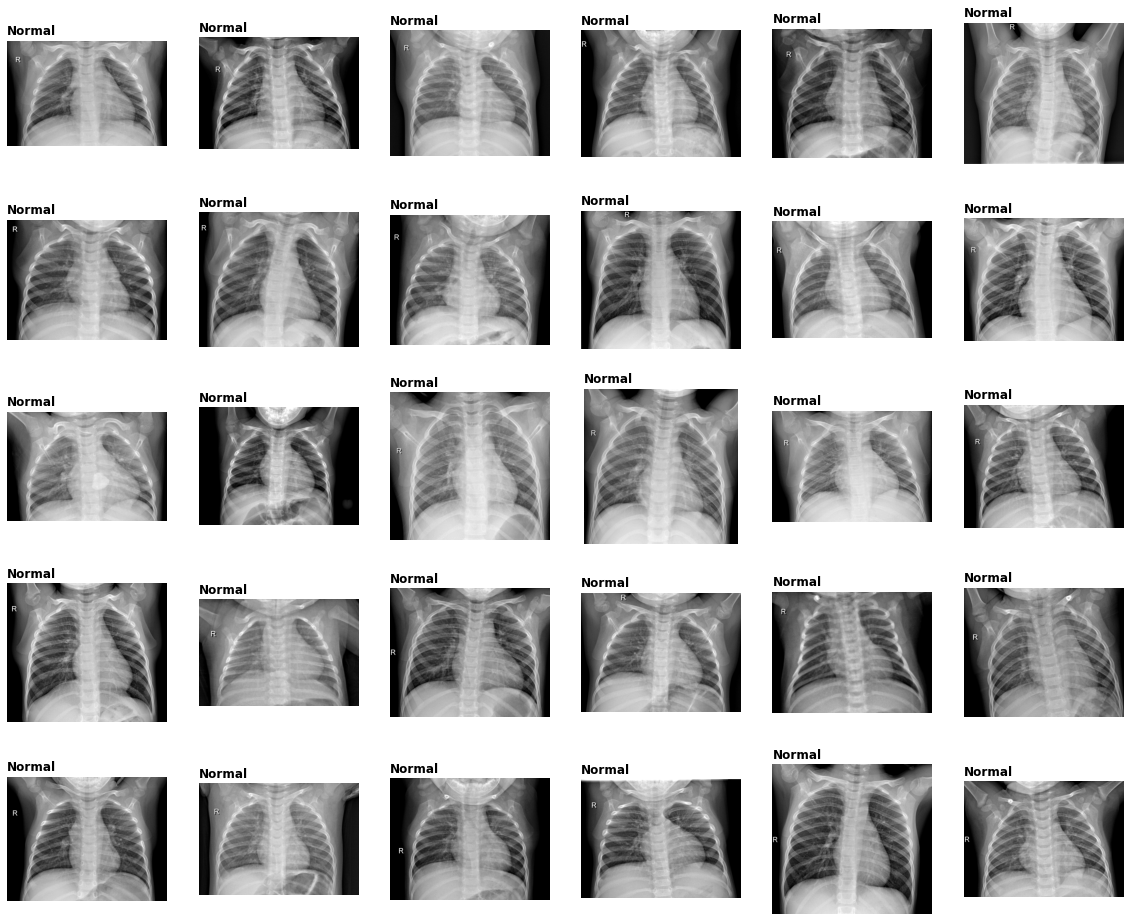

In [9]:
plt.figure(figsize=(20, 20))

for i in range(1 , 31):
    plt.subplot(6, 6, i )
    plt.imshow(Image.open(train_imgs[i]) , cmap = 'gray')
    plt.title(train_df.Label[i], loc = 'left' , weight = 'bold' , color = 'black')
    plt.axis('off')

plt.show()

### **Pneumonia Chest X-ray Examples** ###

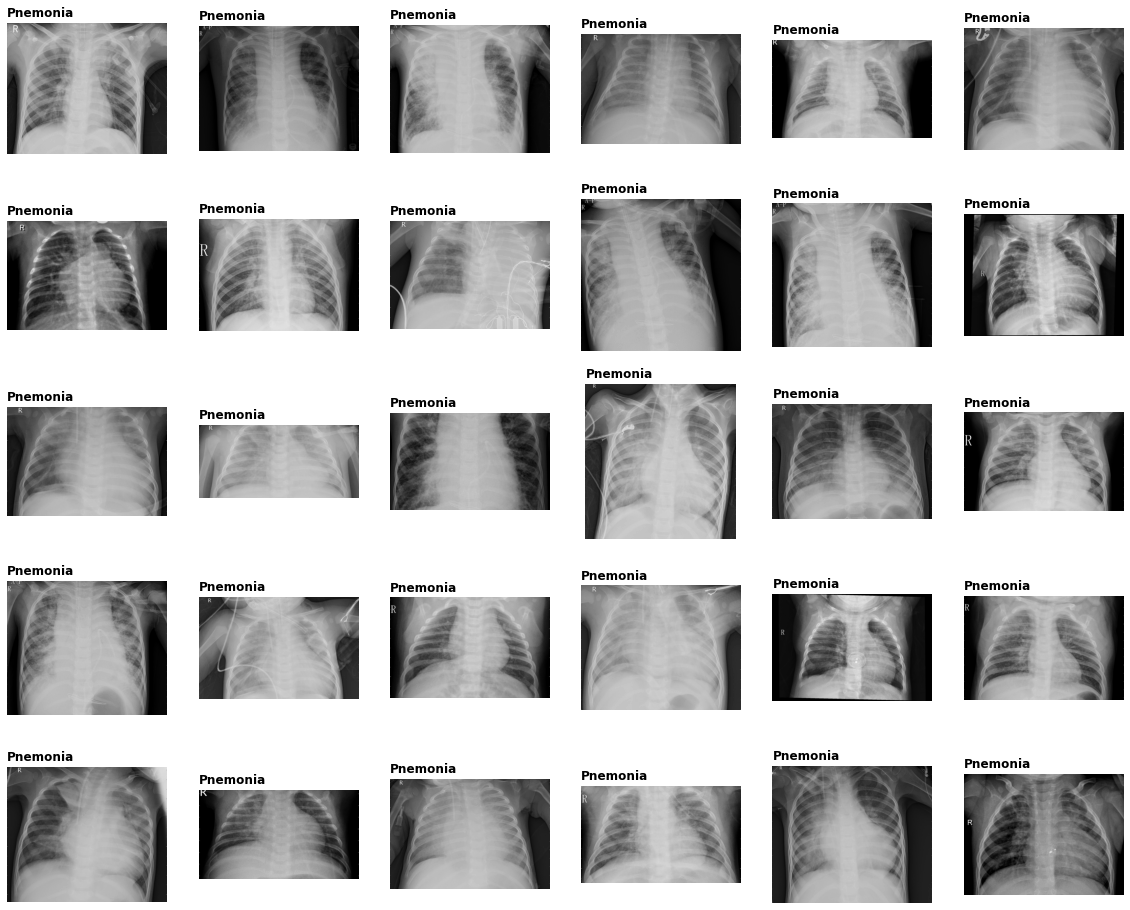

In [10]:
plt.figure(figsize=(20, 20))

for i in range(1 , 31):
    img = pnemonia_idxs[i]
    plt.subplot(6, 6, i )
    plt.imshow(Image.open(train_imgs[img]) , cmap = 'gray')
    plt.title(train_df.Label[img], loc = 'left' , weight = 'bold' , color = 'black')
    plt.axis('off')

plt.show()

### **Preprocessing** ###

In [11]:
train_df['filename'] = train_imgs
test_df['filename'] = test_imgs 

In [12]:
x_train,x_val,y_train,y_val = train_test_split(train_df.X_ray_image_name, train_df.Label)

In [13]:
train_df = pd.DataFrame({'filename':x_train,'label': y_train})
val_df = pd.DataFrame({'filename': x_val , 'label': y_val})

In [14]:
train_df.label.value_counts()

Pnemonia    2950
Normal      1014
Name: label, dtype: int64

In [15]:
val_df.label.value_counts()

Pnemonia    994
Normal      328
Name: label, dtype: int64

In [16]:
datagen = ImageDataGenerator(rescale = 1./255,zoom_range = .1)

train_val_dir = '/content/drive/MyDrive/Data/Covid/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/'


train_data = datagen.flow_from_dataframe(train_df,train_val_dir,
                                         x_col = 'filename' , y_col = 'label',
                                         target_size = (60,60) , color_mode = 'grayscale' ,class_mode = 'binary', shuffle = False )

val_data = datagen.flow_from_dataframe(val_df, train_val_dir,
                                       x_col = 'filename' , y_col = 'label' ,
                                       target_size = (60,60) , color_mode = 'grayscale' , class_mode = 'binary', shuffle = False)

Found 3964 validated image filenames belonging to 2 classes.
Found 1322 validated image filenames belonging to 2 classes.


### **Creating Baseline Model** ###

In [17]:
model1 = Sequential()
model1.add(Conv2D(64,2, padding = 'same', 
                 input_shape = (60,60,1)))
model1.add(Activation('relu'))
model1.add(Conv2D(32, 2 , strides = 2, padding  = 'same'))
model1.add(Activation('relu'))
model1.add(MaxPool2D(pool_size = (2,2)))
model1.add(Conv2D(32, 2 , strides = 2, padding  = 'same'))
model1.add(Activation('relu'))
model1.add(MaxPool2D(pool_size = (2,2)))
model1.add(Dropout(.25))



model1.add(Flatten())
model1.add(Dense(64))
model1.add(Activation('relu'))
model1.add(Dropout(.33))
model1.add(Dense(1, activation= 'sigmoid'))

In [18]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 64)        320       
_________________________________________________________________
activation (Activation)      (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        8224      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          4128      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 32)          0

In [19]:
model1.compile(optimizer = RMSprop(), loss = 'binary_crossentropy' ,metrics = ['acc'])

In [20]:
train_steps = train_data.n // train_data.batch_size
val_steps = val_data.n // val_data.batch_size 

history1 = model1.fit_generator(train_data,train_steps,epochs = 5,
                                validation_data = val_data,
                                validation_steps = val_steps)

Epoch 1/5
123/123 [==============================] - 72s 428ms/step - loss: 0.5860 - acc: 0.7378 - val_loss: 0.4243 - val_acc: 0.8506
Epoch 2/5
123/123 [==============================] - 53s 428ms/step - loss: 0.3925 - acc: 0.8273 - val_loss: 0.2214 - val_acc: 0.9230
Epoch 3/5
123/123 [==============================] - 52s 427ms/step - loss: 0.2670 - acc: 0.8894 - val_loss: 0.2032 - val_acc: 0.9146
Epoch 4/5
123/123 [==============================] - 52s 424ms/step - loss: 0.2442 - acc: 0.8954 - val_loss: 0.1823 - val_acc: 0.9306
Epoch 5/5
123/123 [==============================] - 52s 423ms/step - loss: 0.2130 - acc: 0.9161 - val_loss: 0.1668 - val_acc: 0.9314


In [21]:
test_dir = '/content/drive/MyDrive/Data/Covid/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/'

test_data = datagen.flow_from_dataframe(test_df, test_dir,
                                       x_col = 'filename' , y_col = 'Label' ,
                                       target_size = (60,60) , color_mode = 'grayscale' , class_mode = 'binary', shuffle = False)

Found 624 validated image filenames belonging to 2 classes.


Text(0.0, 1.0, 'Accuracy & Validation Accuracy in Baseline Model')

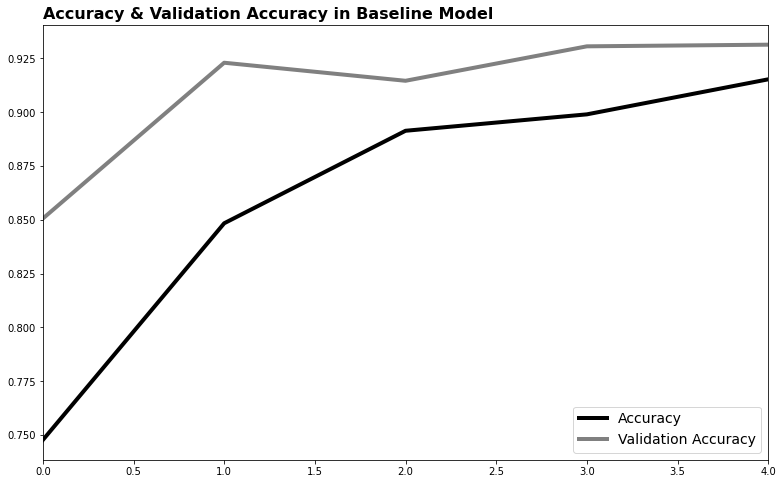

In [22]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']



plt.figure(figsize = (13,8))
plt.plot(range(len(acc)) , acc , color = 'black' , label = 'Accuracy' , linewidth = 4)
plt.plot(val_acc , color = 'grey', label = 'Validation Accuracy', linewidth = 4)
plt.xlim(0 , len(acc) - 1)
plt.legend(fontsize = 14)
plt.title('Accuracy & Validation Accuracy in Baseline Model' , loc = 'left',
          weight = 'bold', fontsize = 16)


In [23]:
model1.evaluate(test_data)

20/20 [==============================] - 5s 244ms/step - loss: 0.6997 - acc: 0.7692


[0.6997475028038025, 0.7692307829856873]

In [24]:
test_data.class_indices

{'Normal': 0, 'Pnemonia': 1}

In [25]:
preds = model1.predict_classes(test_data)

### **Prediction from our Model with 80% of Accuracy** ###

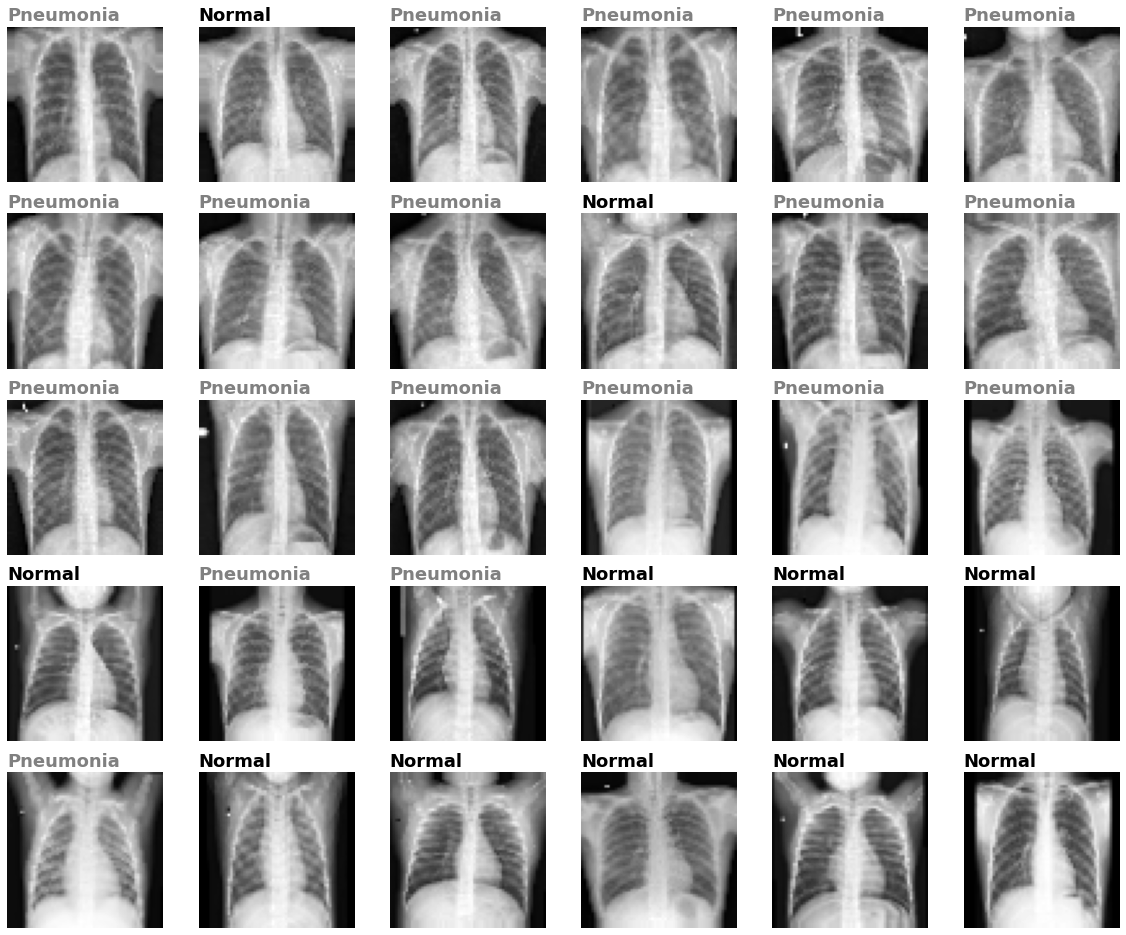

In [26]:
plt.figure(figsize=(20, 20))

for i in range(1 , 31):
    plt.subplot(6, 6, i )
    plt.imshow(test_data[0][0][i].reshape(60,60), cmap = 'gray')
    if preds[i] == 0:
      plt.title('Normal' , color = 'black' , loc = 'left', weight = 'bold' , fontsize = 18)
    if preds[i] == 1:
      plt.title('Pneumonia' , color = 'grey' , loc = 'left' , weight = 'bold' , fontsize = 18)

    plt.axis('off')

plt.show()

In [27]:
#model1.save('model1.h5')

### **Improving our Model** ###

In [28]:
ReducingLearningRate = ReduceLROnPlateau(monitor = 'loss',
                                         verbose = 1,
                                         patience = 20)
EarlyStop = EarlyStopping(monitor ='val_acc' , patience = 2)

###Reducing Layers. Trying a more Parsimonious Structure to Avoid Overfitting ###

In [29]:
model2= Sequential()
model2.add(Conv2D(64,2, padding = 'same', 
                 input_shape = (60,60,1)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, 2 , strides = 2, padding  = 'same'))
model2.add(Activation('relu'))
model2.add(MaxPool2D(pool_size = (2,2)))
model2.add(Dropout(.25))



model2.add(Flatten())
model2.add(Dense(64))
model2.add(Activation('relu'))
model2.add(Dropout(.33))
model2.add(Dense(1, activation= 'sigmoid'))

In [30]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 60, 60, 64)        320       
_________________________________________________________________
activation_4 (Activation)    (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 32)        8224      
_________________________________________________________________
activation_5 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7200)             

In [31]:
train_df = df[: 5286]

In [32]:
x_train,x_val,y_train,y_val = train_test_split(train_df.X_ray_image_name, train_df.Label, test_size =.2)

In [33]:
train_df = pd.DataFrame({'filename':x_train,'label': y_train})
val_df = pd.DataFrame({'filename': x_val , 'label': y_val})

In [34]:
model2.compile(Adam(), loss = 'binary_crossentropy' , metrics = ['acc'])

In [35]:
datagen = ImageDataGenerator(rescale = 1./255)

train_val_dir = '/content/drive/MyDrive/Data/Covid/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/'


train_data = datagen.flow_from_dataframe(train_df,train_val_dir,
                                         x_col = 'filename' , y_col = 'label',
                                         target_size = (60,60) , color_mode = 'grayscale' ,class_mode = 'binary', shuffle = False)

val_data = datagen.flow_from_dataframe(val_df, train_val_dir,
                                       x_col = 'filename' , y_col = 'label' ,
                                       target_size = (60,60) , color_mode = 'grayscale' , class_mode = 'binary', shuffle = False)

Found 4228 validated image filenames belonging to 2 classes.
Found 1058 validated image filenames belonging to 2 classes.


In [36]:
train_steps = train_data.n // train_data.batch_size
val_steps = val_data.n // val_data.batch_size 

history2 = model2.fit_generator(train_data,train_steps,epochs = 15,
                                validation_data = val_data,
                                validation_steps = val_steps,
                                callbacks =[ReducingLearningRate, EarlyStop])

Epoch 1/15
132/132 [==============================] - 51s 383ms/step - loss: 0.4906 - acc: 0.7617 - val_loss: 0.1894 - val_acc: 0.9347
Epoch 2/15
132/132 [==============================] - 50s 383ms/step - loss: 0.1983 - acc: 0.9248 - val_loss: 0.1502 - val_acc: 0.9470
Epoch 3/15
132/132 [==============================] - 50s 382ms/step - loss: 0.1621 - acc: 0.9337 - val_loss: 0.1097 - val_acc: 0.9659
Epoch 4/15
132/132 [==============================] - 50s 376ms/step - loss: 0.1344 - acc: 0.9463 - val_loss: 0.1008 - val_acc: 0.9631
Epoch 5/15
132/132 [==============================] - 50s 377ms/step - loss: 0.1378 - acc: 0.9476 - val_loss: 0.0875 - val_acc: 0.9669
Epoch 6/15
132/132 [==============================] - 50s 378ms/step - loss: 0.0981 - acc: 0.9643 - val_loss: 0.0948 - val_acc: 0.9631
Epoch 7/15
132/132 [==============================] - 50s 376ms/step - loss: 0.1032 - acc: 0.9693 - val_loss: 0.0884 - val_acc: 0.9678
Epoch 8/15
132/132 [==============================] - 5

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fc106a0bdd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 9/15
132/132 [==============================] - 51s 385ms/step - loss: 0.0830 - acc: 0.9698 - val_loss: 0.0793 - val_acc: 0.9744
Epoch 10/15
132/132 [==============================] - 50s 381ms/step - loss: 0.0707 - acc: 0.9794 - val_loss: 0.0823 - val_acc: 0.9678
Epoch 11/15
132/132 [==============================] - 50s 379ms/step - loss: 0.0714 - acc: 0.9743 - val_loss: 0.0876 - val_acc: 0.9716


Text(0.0, 1.0, 'Accuracy & Validation Accuracy')

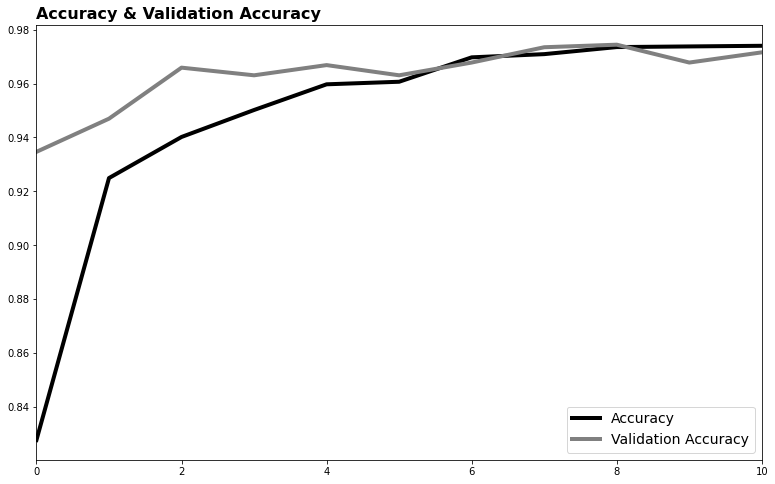

In [37]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']

plt.figure(figsize = (13,8))
plt.plot(range(len(acc)) , acc , color = 'black' , label = 'Accuracy' , linewidth = 4)
plt.plot(val_acc , color = 'grey', label = 'Validation Accuracy', linewidth = 4)
plt.xlim(0 , len(acc) - 1)
plt.legend(fontsize = 14)
plt.title('Accuracy & Validation Accuracy' , loc = 'left',
          weight = 'bold', fontsize = 16)

In [38]:
#model2.save('model2.h5')

In [39]:
model2.evaluate(test_data)

20/20 [==============================] - 5s 238ms/step - loss: 1.3593 - acc: 0.7292


[1.3592677116394043, 0.7291666865348816]

In [40]:
preds = model2.predict_classes(test_data)

In [41]:
test_data.class_indices

{'Normal': 0, 'Pnemonia': 1}

In [42]:
y = test_data.labels

In [43]:
len(y)

624

### **Predição do Modelo para Dados de Validação** ###

*Cores das imagens foram alteradas para melhor visualização do leitor

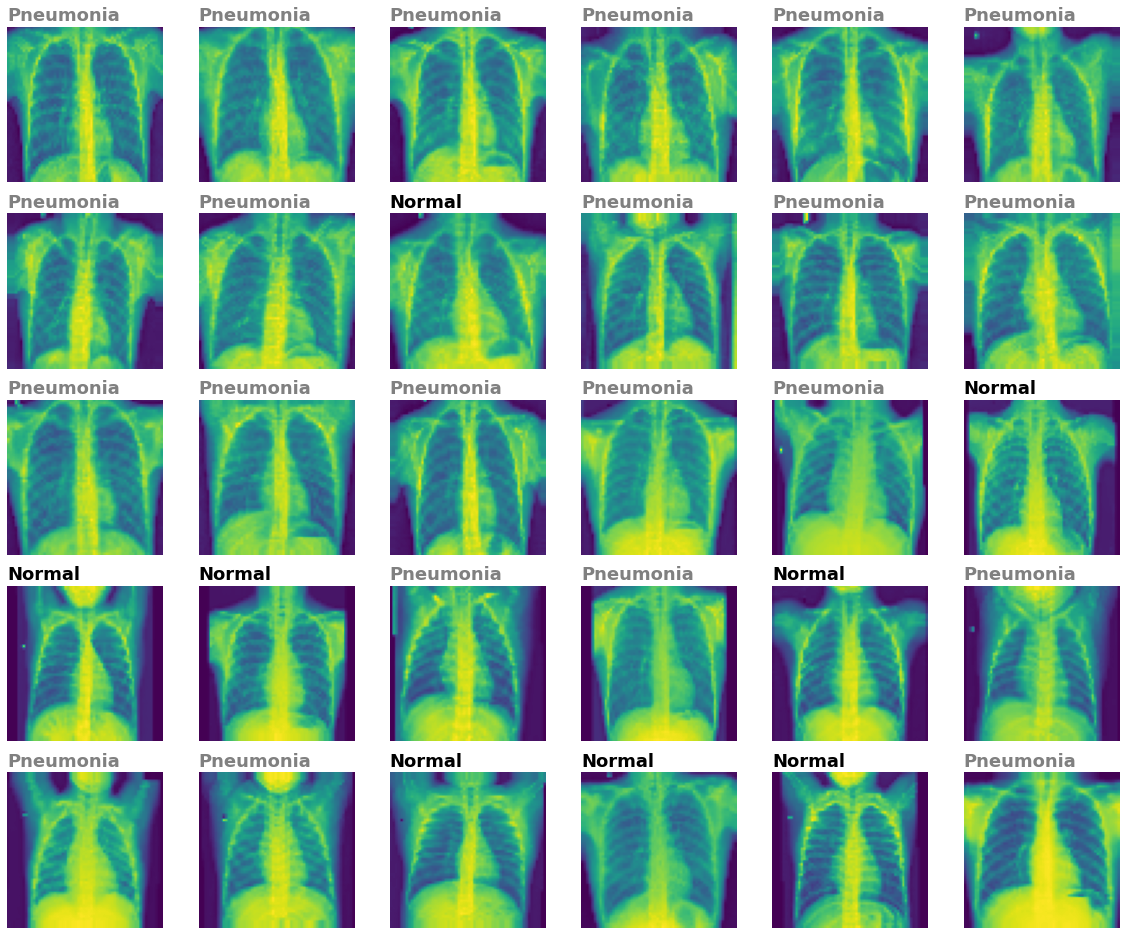

In [44]:
plt.figure(figsize=(20, 20))



for i in range(1 , 31):
    plt.subplot(6, 6, i )
    plt.imshow(test_data[0][0][i].reshape(60,60))
    if preds[i] == 0:
      plt.title('Normal' , color = 'black' , loc = 'left', weight = 'bold' , fontsize = 18)
    if preds[i] == 1:
      plt.title('Pneumonia' , color = 'grey' , loc = 'left' , weight = 'bold' , fontsize = 18)

    plt.axis('off')

plt.show()

### **TransferLearning-Pretrained Models**

###TransferLearning


In [45]:
datagen = ImageDataGenerator(rescale = 1./255)

train_val_dir = '/content/drive/MyDrive/Data/Covid/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/'


train_data = datagen.flow_from_dataframe(train_df,train_val_dir,
                                         x_col = 'filename' , y_col = 'label',
                                         target_size = (224,224) , color_mode = 'rgb' ,class_mode = 'binary', shuffle = True)

val_data = datagen.flow_from_dataframe(val_df, train_val_dir,
                                       x_col = 'filename' , y_col = 'label' ,
                                       target_size = (224,224) , color_mode = 'rgb' , class_mode = 'binary' , shuffle = True)

test_data = datagen.flow_from_dataframe(test_df, test_dir,
                                       x_col = 'filename' , y_col = 'Label' ,
                                       target_size = (224,224) , color_mode = 'rgb' , class_mode = 'binary', shuffle = False)

Found 4228 validated image filenames belonging to 2 classes.
Found 1058 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [46]:
models = {'Resnet50': ResNet50(include_top = False , classes = 2,input_shape = ((224,224,3))),
          'Resnet101':ResNet101(include_top = False , classes = 2,input_shape = ((224,224,3))),
          'InceptionV3':InceptionV3(include_top = False , classes = 2,input_shape = ((224,224,3))),
          'InceptionResnet':InceptionResNetV2(include_top = False , classes = 2,input_shape = ((224,224,3))),
          'VGG19':VGG19(include_top = False  , classes = 2,input_shape = ((224,224,3))),
          'VGG16':VGG16(include_top = False , classes = 2,input_shape = ((224,224,3)))}

In [47]:
def step_decay(epoch):
   initial_lrate = 0.1
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

Learning_Schedule = LearningRateScheduler(schedule = step_decay)
EarlyStop = EarlyStopping(monitor = 'val_loss', patience = 1 )

_______________________________________________________
_______________________________________________________


Training : Resnet50
Epoch 1/20
132/132 [==============================] - 105s 476ms/step - loss: 0.8446 - acc: 0.6783 - val_loss: 0.6156 - val_acc: 0.7386
Epoch 2/20
132/132 [==============================] - 62s 472ms/step - loss: 0.5985 - acc: 0.7533 - val_loss: 0.5813 - val_acc: 0.7377
Epoch 3/20
132/132 [==============================] - 62s 468ms/step - loss: 0.5723 - acc: 0.7473 - val_loss: 0.5755 - val_acc: 0.7377
Epoch 4/20
132/132 [==============================] - 62s 469ms/step - loss: 0.5741 - acc: 0.7407 - val_loss: 0.5745 - val_acc: 0.7386
Epoch 5/20
20/20 [==============================] - 6s 300ms/step - loss: 0.6972 - acc: 0.6250



20/20 [==============================] - 6s 300ms/step - loss: 0.6972 - acc: 0.6250
------> EvaluatingResnet50 : [0.6972163915634155, 0.625] Accuracy in Test_data


------------------- Resnet50 History ----------------------


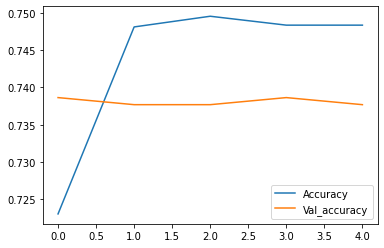

_______________________________________________________
_______________________________________________________


Training : Resnet101
Epoch 1/20
132/132 [==============================] - 74s 513ms/step - loss: 1.0360 - acc: 0.6622 - val_loss: 0.3709 - val_acc: 0.7377
Epoch 2/20
132/132 [==============================] - 66s 500ms/step - loss: 0.4353 - acc: 0.7380 - val_loss: 0.3261 - val_acc: 0.7386
Epoch 3/20
132/132 [==============================] - 66s 501ms/step - loss: 0.4124 - acc: 0.7404 - val_loss: 0.2949 - val_acc: 0.7386
Epoch 4/20
132/132 [==============================] - 66s 498ms/step - loss: 0.4094 - acc: 0.7430 - val_loss: 0.2931 - val_acc: 0.7396
Epoch 5/20
132/132 [==============================] - 66s 500ms/step - loss: 0.4040 - acc: 0.7522 - val_loss: 0.2740 - val_acc: 0.7377
Epoch 6/20
20/20 [==============================] - 7s 324ms/step - loss: 0.5143 - acc: 0.6250



20/20 [==============================] - 7s 324ms/step - loss: 0.5143 - acc: 0.6250
------> 

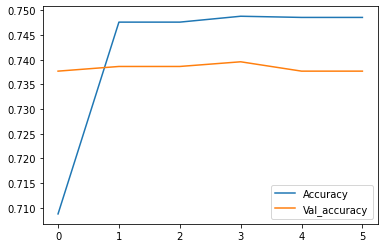

_______________________________________________________
_______________________________________________________


Training : InceptionV3
Epoch 1/20
132/132 [==============================] - 68s 477ms/step - loss: 1.2322 - acc: 0.7801 - val_loss: 0.1491 - val_acc: 0.9422
Epoch 2/20
20/20 [==============================] - 6s 300ms/step - loss: 0.9087 - acc: 0.6458



20/20 [==============================] - 6s 301ms/step - loss: 0.9087 - acc: 0.6458
------> EvaluatingInceptionV3 : [0.9086953401565552, 0.6458333134651184] Accuracy in Test_data


------------------- InceptionV3 History ----------------------


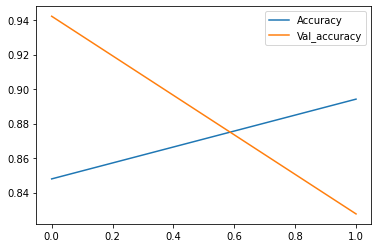

_______________________________________________________
_______________________________________________________


Training : InceptionResnet
Epoch 1/20
132/132 [==============================] - 81s 529ms/step - loss: 2.3095 - acc: 0.7643 - val_loss: 0.1466 - val_acc: 0.9403
Epoch 2/20
132/132 [==============================] - 66s 502ms/step - loss: 0.2068 - acc: 0.9223 - val_loss: 0.1143 - val_acc: 0.9489
Epoch 3/20
20/20 [==============================] - 8s 357ms/step - loss: 0.3517 - acc: 0.8814



20/20 [==============================] - 7s 327ms/step - loss: 0.3517 - acc: 0.8814
------> EvaluatingInceptionResnet : [0.3516541123390198, 0.8814102411270142] Accuracy in Test_data


------------------- InceptionResnet History ----------------------


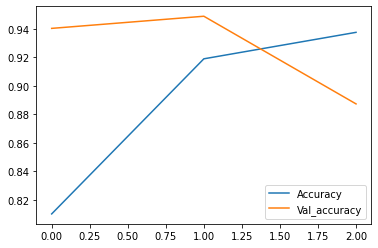

_______________________________________________________
_______________________________________________________


Training : VGG19
Epoch 1/20
132/132 [==============================] - 73s 496ms/step - loss: 0.5065 - acc: 0.8079 - val_loss: 0.0857 - val_acc: 0.9678
Epoch 2/20
132/132 [==============================] - 64s 484ms/step - loss: 0.1223 - acc: 0.9579 - val_loss: 0.0667 - val_acc: 0.9735
Epoch 3/20
132/132 [==============================] - 64s 485ms/step - loss: 0.1169 - acc: 0.9594 - val_loss: 0.0662 - val_acc: 0.9782
Epoch 4/20
132/132 [==============================] - 64s 485ms/step - loss: 0.0795 - acc: 0.9736 - val_loss: 0.0495 - val_acc: 0.9811
Epoch 5/20
20/20 [==============================] - 10s 494ms/step - loss: 1.1217 - acc: 0.8109



20/20 [==============================] - 7s 308ms/step - loss: 1.1217 - acc: 0.8109
------> EvaluatingVGG19 : [1.1216917037963867, 0.8108974099159241] Accuracy in Test_data


------------------- VGG19 History ---------------------

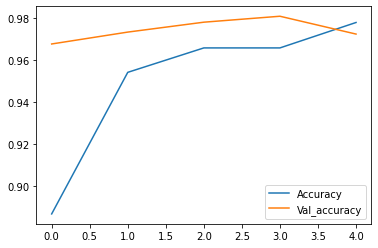

_______________________________________________________
_______________________________________________________


Training : VGG16
Epoch 1/20
132/132 [==============================] - 65s 483ms/step - loss: 0.4135 - acc: 0.8483 - val_loss: 0.0798 - val_acc: 0.9716
Epoch 2/20
132/132 [==============================] - 64s 482ms/step - loss: 0.1230 - acc: 0.9633 - val_loss: 0.0635 - val_acc: 0.9763
Epoch 3/20
20/20 [==============================] - 7s 316ms/step - loss: 0.4396 - acc: 0.8606



20/20 [==============================] - 7s 310ms/step - loss: 0.4396 - acc: 0.8606
------> EvaluatingVGG16 : [0.4395918846130371, 0.8605769276618958] Accuracy in Test_data


------------------- VGG16 History ----------------------


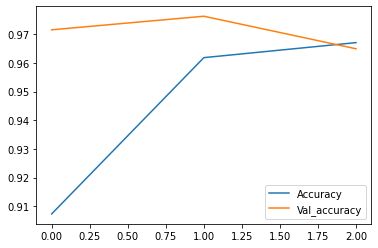

In [52]:


def build_model(base):
  model = Sequential()
  base.trainable = False
  model.add(base)
  model.add(Flatten())
  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(.25))
  model.add(Dense(32 , activation = 'relu'))
  model.add(Dropout(.25))
  model.add(Dense(1, activation = 'sigmoid'))
  return model 


name = [] 
val_test_data = [] 

for MODEL in models:
  print('_______________________________________________________')
  print('_______________________________________________________')
  print('\n')
  print('Training : {}'.format(MODEL))
  base = models[MODEL]
  model = build_model(base)
  model.compile('adam' , loss = 'binary_crossentropy', metrics = ['acc'])
  train_steps = train_data.n // train_data.batch_size
  val_steps = val_data.n // val_data.batch_size
  history = model.fit_generator(train_data,train_steps,epochs = 20,
                                validation_data = val_data,
                                validation_steps = val_steps,
                                callbacks = [EarlyStop])
  
  eval = model.evaluate(test_data)
  print('\n\n')
  print('------> Evaluating{} : {} Accuracy in Test_data'.format(MODEL,model.evaluate(test_data)))
  print('\n')
  print('------------------- {} History ----------------------'.format(MODEL))
  acc = history.history['acc']
  val_acc = history.history['val_acc']



  plt.plot(range(0,len(acc)),acc,label = 'Accuracy')
  plt.plot(val_acc , label = 'Val_accuracy')
  plt.legend()
  plt.show()
  name.append(MODEL)
  val_test_data.append(eval[1])

In [54]:
results = pd.DataFrame({'models':name , 'accuracy':val_test_data})
results

models  accuracy
0         Resnet50  0.625000
1        Resnet101  0.625000
2      InceptionV3  0.645833
3  InceptionResnet  0.881410
4            VGG19  0.810897
5            VGG16  0.860577

In [56]:
results = results.sort_values(by = 'accuracy', ascending = False)
results

models  accuracy
3  InceptionResnet  0.881410
5            VGG16  0.860577
4            VGG19  0.810897
2      InceptionV3  0.645833
0         Resnet50  0.625000
1        Resnet101  0.625000

Text(0, 0.5, ' ')

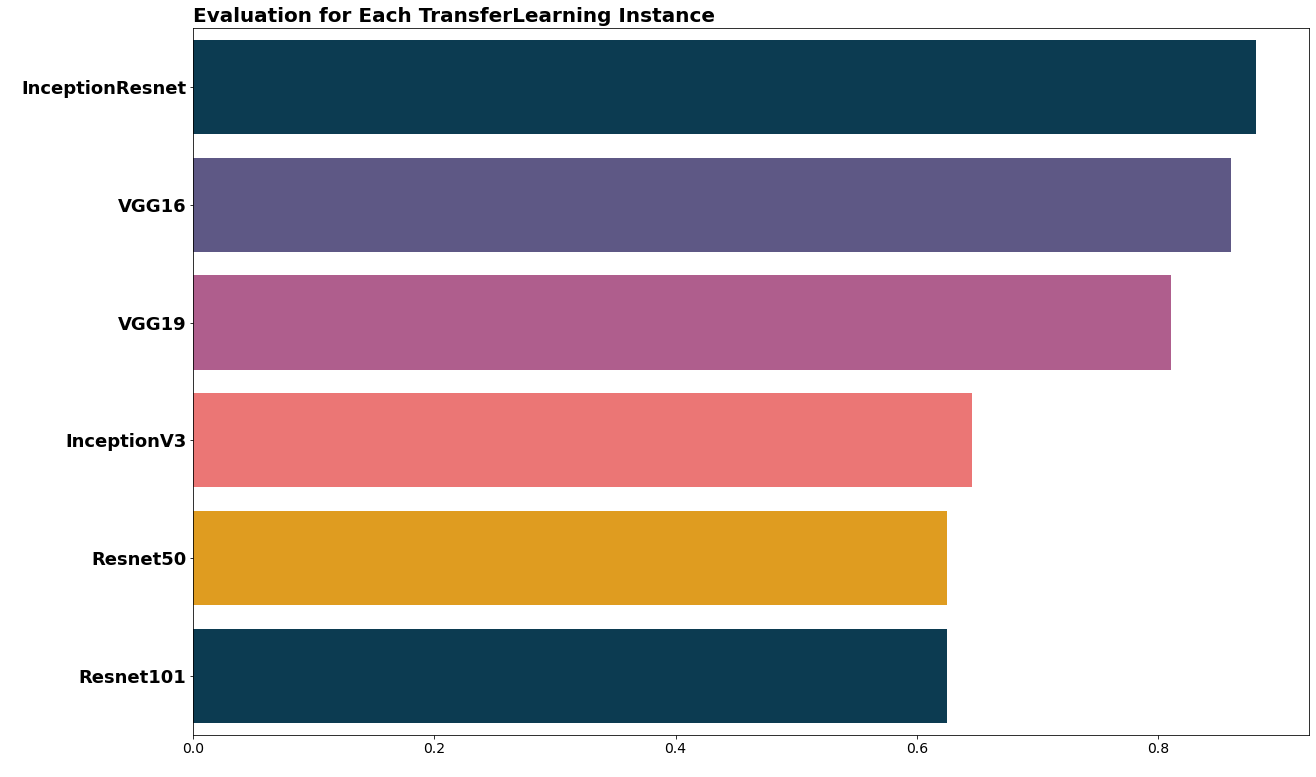

In [59]:
plt.figure(figsize = (20,13))
k = ['#003f5c' ,'#58508d' ,'#bc5090' ,'#ff6361' ,'#ffa600']
sns.barplot(x = results.accuracy , y = results.models, palette = k)
plt.xticks(size = 14)
plt.yticks(size = 18 , weight = 'bold')
plt.title('Evaluation for Each TransferLearning Instance' , fontsize = 20 , weight = 'bold' , loc = 'left')
plt.xlabel(' ')
plt.ylabel(' ')

In [61]:
model = build_model(models['InceptionResnet'])
model.compile('adam' , loss = 'binary_crossentropy', metrics = ['acc'])
model.fit_generator(train_data,train_steps,epochs = 20,
                                validation_data = val_data,
                                validation_steps = val_steps,
                                callbacks = [EarlyStop])

Epoch 1/20
132/132 [==============================] - 81s 532ms/step - loss: 1.4847 - acc: 0.7772 - val_loss: 0.1608 - val_acc: 0.9366
Epoch 2/20
132/132 [==============================] - 66s 502ms/step - loss: 0.1911 - acc: 0.9077 - val_loss: 0.1061 - val_acc: 0.9564
Epoch 3/20
132/132 [==============================] - 66s 502ms/step - loss: 0.1398 - acc: 0.9489 - val_loss: 0.1339 - val_acc: 0.9176


In [72]:
model.evaluate_generator(test_data)[1] #transferleaning almost 10 percent gain in accuracy

0.8365384340286255

In [63]:
pred = model.predict_classes(test_data)

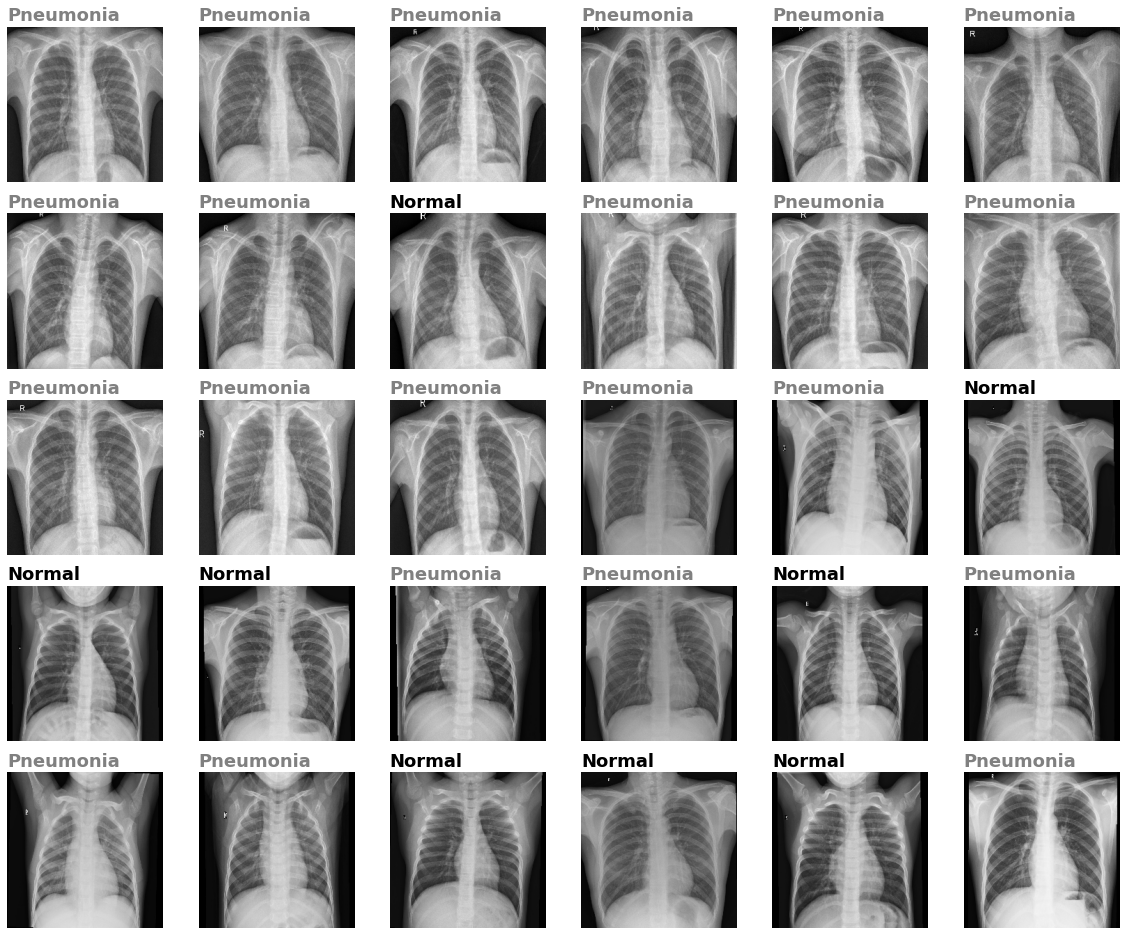

In [76]:
plt.figure(figsize=(20, 20))



for i in range(1 , 31):
    plt.subplot(6, 6, i )
    plt.imshow(test_data[0][0][i].reshape(224,224,3))
    if preds[i] == 0:
      plt.title('Normal' , color = 'black' , loc = 'left', weight = 'bold' , fontsize = 18)
    if preds[i] == 1:
      plt.title('Pneumonia' , color = 'grey' , loc = 'left' , weight = 'bold' , fontsize = 18)

    plt.axis('off')

plt.show()